In [2]:
from typing import Tuple, NamedTuple, Set, Mapping, Sequence
from itertools import chain, product, groupby
import numpy as np
from numpy.core.multiarray import ndarray
from scipy.stats import lognorm
from processes.mdp_refined import MDPRefined
from func_approx.dnn_spec import DNNSpec
from func_approx.func_approx_base import FuncApproxBase
from func_approx_spec import FuncApproxSpec
from copy import deepcopy
from operator import itemgetter
from processes.det_policy import DetPolicy
from dp.dp_analytic import DPAnalytic
from dp.dp_numeric import DPNumeric
import json
import os
import FigureFunc

StateType = Tuple[int, ...]
# DP algorithm

class InvEnv(NamedTuple):
    L_max: float
    L_min: float
    mu_inflow: Sequence[float]
    sigma_inflow: Sequence[float]
    mu_price: Sequence[float]
    sigma_price: Sequence[float]
    epoch_disc_factor: float
    failure_cost: float
    condition_ini: float
    av_det: float
    adjust_rate: float
    prod_cap: float
    len_month: int
    gran: float

    def validate_spec(self) -> bool:
        b1 = self.L_max > 0.
        b2 = self.L_min >= 0
        #b3 = self.mu_inflow > 0.
        #b4 = self.sigma_inflow >= 0.
        b5 = 0. <= self.epoch_disc_factor <= 1.
        #b6 = self.mu_price > 0.
        #b7 = self.sigma_price > 0.
        b8 = self.failure_cost > 0.
        return all([b1, b2, b5, b8])

    def get_all_states(self) -> Set[StateType]:
        # reservior level
        on_hand_range = list(np.arange(int(self.L_min), int(self.L_max + 1), self.gran))
        if self.av_det == 0:
            current_cond = list([0])
        else:
            current_cond = list(np.arange(self.condition_ini, 101, self.av_det))
        month = range(self.len_month)
        return set(product(
            *chain([on_hand_range], [current_cond], [month])
        ))


    def get_next_states_probs_rewards(
            self,
            state: StateType,
            action: int,
            inflow_probs:  Sequence[float],
            price_probs: Sequence[float], 
            model
    ) -> Mapping[StateType, Tuple[float, float]]:
        next_state_arr: ndarray = np.array(state)
        #print("next_state_arr, action", next_state_arr, action)
        # The next line represents state change due to Action and Receipt[1 if next_state_arr[2] < 11 else -11]
        next_state_arr += np.append([-action *self.adjust_rate, self.av_det if action > 0. else 0],
                                    [1 if next_state_arr[2] < self.len_month-1 else -(self.len_month-1)])
        #next_state_arr += np.append(-action *self.adjust_rate, self.av_det if action > 0 else 0.)

        # The next line represents state change due to demand
        temp_list = []

        for price, prob_pr in price_probs:
            #there is no need to create a cost for the failure since we can ensure that the plant never fails by considering 
            # the initial condition to be less than a threshold
            reward = action * price if next_state_arr[1] <= 100. else 0.
            #- (self.failure_cost if next_state_arr[1] > 1. else 0.)  
            
            for inflow, prob_in in inflow_probs:
                #print("inflow : {}, next_state_arr[0] : {}".format(inflow, next_state_arr[0]))
                next_state_arr[0] = min(inflow+next_state_arr[0], self.L_max)
                ns = deepcopy(next_state_arr)
                inv = ns[0]
                cond = ns[1]
                onhand = inv
                ns_tup = tuple(x for x in ns)
                temp_list.append((ns_tup, prob_pr, prob_in, reward))

        ret = {}
        crit = itemgetter(0)
        for s, v in groupby(sorted(temp_list, key=crit), key=crit):
            tl = [(p1, p2, r) for _, p1, p2, r in v]
            sum_p1 = sum(p1/len(inflow_probs) for p1, _, _ in tl)
            
            sum_p2 = sum(p2/len(price_probs) for _, p2, _ in tl)
            #print(s, sum_p2)
            if model == "nominal":
                avg_r = sum((p1/len(inflow_probs) * r 
                            for p1, _, r in tl))/(sum_p1) if sum_p1 != 0. else 0.
                #print("sum of probabilities",sum((p2/len(price_probs) for _, p2, _ in tl))/(sum_p2) if sum_p2 != 0. else 0.)
                #print("action, avg_r", action, avg_r)
                ret[s] = (sum_p2, avg_r)
                
#                 print("state:", s)
#                 print("action: {}, reward : {}".format(action, ret[s][1]))
            elif model == "robust":
                r_list = [r for p1, _, r in tl if p1 != 0]
#                 print(s)
#                 print(action, r_list)
                if r_list:
                    worst_r = min(r_list)
                    worst_r = sum((p1/len(inflow_probs) * worst_r 
                            for p1, _, _ in tl))/(sum_p1) if sum_p1 != 0. else 0.
                    
                else:
                    worst_r = 0.

                ret[s] = (sum_p2, worst_r)
            else:
                raise ValueError("Model is not selected appropriately")
                
        return ret

    def get_mdp_refined_dict(self, model) \
            -> Mapping[StateType,
                       Mapping[int,
                               Mapping[StateType,
                                       Tuple[float, float]]]]:
        ret_price, ret_inflow = self.get_exogenous_state()
        #print("pp_inflow", pp_inflow)
        return {s: {a: self.get_next_states_probs_rewards(s, a, ret_inflow[s[-1]], ret_price[s[-1]], model)
                    for a in np.arange(0, self.get_all_actions(s), self.gran)}
                for s in self.get_all_states()}

    def get_exogenous_state(self):
        # self.mu_price is a list
        rv_price = [0] * self.len_month
        rv_inflow = [0] * self.len_month
        raw_price_probs = [0] * self.len_month
        raw_inflow_probs = [0] * self.len_month
        pp_price = [0] * self.len_month
        pp_inflow = [0] * self.len_month
        ret_inflow = [[] for _ in range(self.len_month)]
        ret_price = [[] for _ in range(self.len_month)]
        for month in range(self.len_month):
            rv_price[month] = lognorm(s= self.sigma_price[month], scale = self.mu_price[month])
            rv_inflow[month] = lognorm(s = self.sigma_inflow[month], scale = self.mu_inflow[month])
            raw_price_probs[month] = [rv_price[month].cdf(i) for i in np.arange(0, int(rv_price[month].ppf(0.95)), self.gran)]
            raw_inflow_probs[month] = [rv_inflow[month].cdf(i) for i in np.arange(0, int(rv_inflow[month].ppf(0.95)), self.gran)]
            pp_price[month] = [p / sum(raw_price_probs[month]) for p in raw_price_probs[month]]
            pp_inflow[month] = [p / sum(raw_inflow_probs[month]) for p in raw_inflow_probs[month]]
            for i, num in enumerate(np.arange(0, int(rv_price[month].ppf(0.95)), self.gran)):
                ret_price[month].append([num, pp_price[month][i]])
            for i, num in enumerate(np.arange(0, int(rv_inflow[month].ppf(0.95)), self.gran)):
                ret_inflow[month].append([num, pp_inflow[month][i]])
            #print(ret_inflow[month])
                
        #print({month: ret_inflow[month] for month in range(self.len_month)})
        return {month: ret_price[month] for month in range(self.len_month)}, {month: ret_inflow[month] for month in range(self.len_month)}
        
            
            

    # Actions given the inventory 
    def get_all_actions(self, state):
        if state[1] >= 100:
            cap = self.gran
        else:
            cap = max(min(self.prod_cap, (state[0] - self.L_min)* (1/self.adjust_rate)), self.gran)
#             if state[0] > 90:
#                 print("cap", cap)
        return cap
        
        
        
    def get_mdp_refined(self, model) -> MDPRefined:
        return MDPRefined(self.get_mdp_refined_dict(model), self.epoch_disc_factor)

    def get_optimal_policy(self) -> DetPolicy:
        return self.get_mdp_refined().get_optimal_policy()

    def get_ips_orders_dict(self) -> Mapping[int, Sequence[int]]:
        sa_pairs = self.get_optimal_policy().get_state_to_action_map().items()

        def crit(x: Tuple[Tuple[int, ...], int]) -> int:
            return sum(x[0])

        return {ip: [y for _, y in v] for ip, v in
                groupby(sorted(sa_pairs, key=crit), key=crit)}


if __name__ == '__main__':
    import time
    start = time.time()
    #initial parameters
    kwargs = {"L_max":500, "L_min":1. ,"mu_inflow":[1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 2., 2., 2., 1.5, 1.5, 1.5],
              "sigma_inflow":[0.8] * 12, "mu_price": [3., 3., 3., 2., 2., 2., 1., 1., 1., 2., 2., 2.] * 12,
              "sigma_price": [1.] *12, "epoch_disc_factor":0.95, "gran": 0.5, "failure_cost":10., "condition_ini":0.,
              "av_det": 5, "adjust_rate": 1, "prod_cap": 20., "len_month":12}

#    kwargs = {"L_max":50., "L_min":40. ,"mu_inflow":[1., 1., 1., 1.5, 1.5, 1.5, 2., 2., 2., 1.5, 1.5, 1.5]  , "sigma_inflow":[0.5] * 12,
#          "mu_price": [3., 3., 3., 2., 2., 2., 1., 1., 1., 2., 2., 2.] * 12,"sigma_price": [0.5] *12, "epoch_disc_factor":0.95, "gran": 0.5,
#          "failure_cost":10., "condition_ini":0., "av_det": 0.,"adjust_rate": 1, "prod_cap": 20., "len_month":12}



    # month and reservior level
#     kwargs = {"L_max":200., "L_min":40. ,"mu_inflow":[1., 1., 1., 1.5, 1.5, 1.5, 2., 2., 2., 1.5, 1.5, 1.5]  , "sigma_inflow":[0.5] * 12,
#           "mu_price": [3., 3., 3., 2., 2., 2., 1., 1., 1., 2., 2., 2.] * 12,"sigma_price": [0.5] *12, "epoch_disc_factor":0.95, "gran": 0.5,
#           "failure_cost":10., "condition_ini":0., "av_det": 0.,"adjust_rate": 1, "prod_cap": 20., "len_month":12}

    # reservior level and condition of plant
#     kwargs = {"L_max":20., "L_min":1. ,"mu_inflow":[3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 5., 5., 5.]  , "sigma_inflow":[1.] * 12,
#           "mu_price": [2.] * 12,"sigma_price": [0.5] *12, "epoch_disc_factor":0.96, 
#           "failure_cost":10., "condition_ini":0., "av_det": 0.2,"adjust_rate": 1, "prod_cap": 5., "len_month":1}



#     resservior level
#    kwargs = {"L_max":100., "L_min":1. ,"mu_inflow":[1., 1., 1., 2., 2., 2., 3., 3., 3., 2., 2., 2.]  , "sigma_inflow":[0.5] * 12,
#            "mu_price": [2.] * 12,"sigma_price": [0.5] *12, "epoch_disc_factor":0.95, "gran": 1.,
#           "failure_cost":10., "condition_ini":0., "av_det": 0.,"adjust_rate":1,"prod_cap": 10.,
#           "len_month":1}

    inv = InvEnv(**kwargs)
    States = inv.get_all_states()
    
    if not inv.validate_spec():
        raise ValueError
    mdp_ref_obj_nominal = inv.get_mdp_refined(model = "nominal")
    #mdp_ref_obj_robust = inv.get_mdp_refined(model = "robust")
    this_tolerance = 1e-4
    dp_obj_nominal = DPNumeric(mdp_ref_obj_nominal, this_tolerance)
    #dp_obj_robust = DPNumeric(mdp_ref_obj_robust, this_tolerance)
    
    def criter(x: Tuple[Tuple[int, ...], int]) -> int:
        return sum(x[0])

    opt_policy, value_function = dp_obj_nominal.get_optimal_policy_vi()
    #opt_policy_robust, value_function_robust = dp_obj_robust.get_optimal_policy_Robust_vi()        
    experiment_path = "Results/"
    if not os.path.exists(experiment_path):
        os.makedirs(experiment_path)
    if not os.path.exists(experiment_path + "/DP/"):
        os.makedirs(experiment_path + "/DP/")
    config_path = experiment_path + "/DP/config.json"
    with open(config_path, "w") as f:
        json.dump(kwargs, f)
    results = experiment_path + "/DP/VF_Pol.txt"
    output= open(results, 'wt')
    for s in States:
        output.write("States: {}, Optimal value function: {}\n".format(s, value_function[s]))
        #print("States: {}, Optimal value function: {}\n".format(s, value_function[s]))
    #output.write("#######################Policy########################")
    #output.write("Policy: {}\n".format(opt_policy))
    end = time.time()
    execution_time = end - start
    output.write("Execution time: {}".format(execution_time))
    output.close()



#     Data = {}
#     import matplotlib
#     import matplotlib.pyplot as plt
#     month = []
#     res_level = []
#     for s in States:
#         if s[2] == 7:
#             Data[s[0]] = value_function[s]
    
#     for key in Data.keys():
#         res_level.append(key)
#     res_level = sorted(set(res_level))
#     values = np.zeros(len(res_level))
#     for i, elem1 in enumerate(res_level):
#         values[i] = Data[elem1]
#     der_value = np.zeros(len(res_level)-1)
#     der_res = np.zeros(len(res_level)-1)
#     for num in range(1, len(res_level)):
#         der_value[num-1] = (values[num] - values[num-1]) /kwargs['gran']
#         der_res[num-1] = res_level[num] 
    
#     #res_level and derivative
#     fig = plt.figure()
#     fig.subplots_adjust()
#     ax1 = fig.add_subplot(111)
#     ax1.set_xlabel("reservior level")
#     ax1.set_title("Value Iteration")
#     ax1.set_xlim(kwargs['L_min'], kwargs['L_max'])
#     ax1.plot(der_res, der_value, label = "Der. of VF with granularity %s"%kwargs['gran'])
#     #ax1.plot(res_level, values, label = "Value function")
#     ax1.legend()
#     plt.show()    
#     policyplot(opt_policy, States, kwargs["prod_cap"])
#     policyplot(opt_policy_robust, States, kwargs["prod_cap"])
    

KeyboardInterrupt: 

In [25]:
from scipy.stats import lognorm
import numpy as np
import math
rv_price = lognorm(s = 0.487, scale = math.exp(4.54))
raw_price_probs = [rv_price.cdf(i) for i in np.arange(int(rv_price.ppf(0.05)), int(rv_price.ppf(0.95)), 1)]
pp_price = [p / sum(raw_price_probs) for p in raw_price_probs]
pp_price

[0.00047664874665300937,
 0.0005261306504129106,
 0.0005783117103002061,
 0.0006331518585935006,
 0.0006906019039707573,
 0.0007506042739571058,
 0.000813093767064197,
 0.0008779983052017385,
 0.0009452396782657914,
 0.0010147342740483398,
 0.0010863937877593534,
 0.0011601259065011616,
 0.0012358349649839676,
 0.0013134225696218448,
 0.0013927881889035298,
 0.0014738297085963518,
 0.001556443950919958,
 0.0016405271573252775,
 0.001725975434939568,
 0.0018126851670970782,
 0.001900553388673057,
 0.0019894781271827745,
 0.0020793587108029273,
 0.002170096044625782,
 0.00226159285657185,
 0.0023537539144697943,
 0.0024464862158668356,
 0.0025396991521633647,
 0.0026333046486753343,
 0.002727217282220519,
 0.002821354377802984,
 0.0029156360859363874,
 0.003009985442103691,
 0.003104328409800129,
 0.003198593908549862,
 0.0032927138282260273,
 0.0033866230309402214,
 0.0034802593417018516,
 0.0035735635289813445,
 0.003666479276244605,
 0.003758953145459967,
 0.0038509345335139005,
 0.00

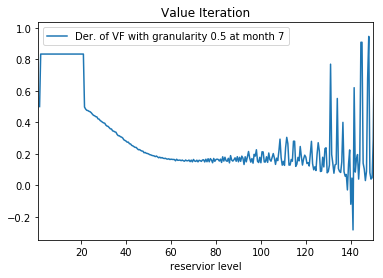

In [26]:
    Data = {}
    import matplotlib
    import matplotlib.pyplot as plt
    time = 7
    month = []
    res_level = []
    for s in States:
        if s[2] == time:
            Data[s[0]] = value_function[s]
    
    for key in Data.keys():
        res_level.append(key)
    res_level = sorted(set(res_level))
    values = np.zeros(len(res_level))
    for i, elem1 in enumerate(res_level):
        values[i] = Data[elem1]
    der_value = np.zeros(len(res_level)-1)
    der_res = np.zeros(len(res_level)-1)
    for num in range(1, len(res_level)):
        der_value[num-1] = (values[num] - values[num-1]) /kwargs['gran']
        der_res[num-1] = res_level[num] 
    
    #res_level and derivative
    fig = plt.figure()
    fig.subplots_adjust()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel("reservior level")
    ax1.set_title("Value Iteration")
    ax1.set_xlim(kwargs['L_min'], kwargs['L_max'])
    ax1.plot(der_res, der_value, label = "Der. of VF with granularity %s at month %s"%(kwargs['gran'], time))
    #ax1.plot(res_level, values, label = "Value function")
    ax1.legend()
    plt.show()    

In [15]:
Data

{1.0: 2956.274384181007,
 1.5: 2956.3271985460301,
 2.0: 2957.3958373350979,
 2.5: 2958.4644761241661,
 3.0: 2959.5331149132339,
 3.5: 2960.6017537023017,
 4.0: 2961.67039249137,
 4.5: 2962.7390312804378,
 5.0: 2963.8076700695055,
 5.5: 2964.8763088585738,
 6.0: 2965.9449476476416,
 6.5: 2967.0135864367094,
 7.0: 2968.0822252257776,
 7.5: 2969.1508640148454,
 8.0: 2970.2195028039132,
 8.5: 2971.2881415929814,
 9.0: 2972.3567803820492,
 9.5: 2973.425419171117,
 10.0: 2974.4940579601853,
 10.5: 2975.5626967492531,
 11.0: 2976.6313355383209,
 11.5: 2977.6999743273891,
 12.0: 2978.7686131164569,
 12.5: 2979.8372519055247,
 13.0: 2980.9058906945929,
 13.5: 2981.9745294836607,
 14.0: 2983.0431682727285,
 14.5: 2984.1118070617968,
 15.0: 2985.1804458508645,
 15.5: 2986.2490846399323,
 16.0: 2987.3177234290006,
 16.5: 2988.3863622180684,
 17.0: 2989.4550010071362,
 17.5: 2990.5236397962044,
 18.0: 2991.5922785852722,
 18.5: 2992.66091737434,
 19.0: 2993.7295561634082,
 19.5: 2994.798194952476,

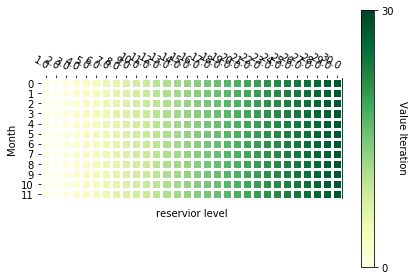

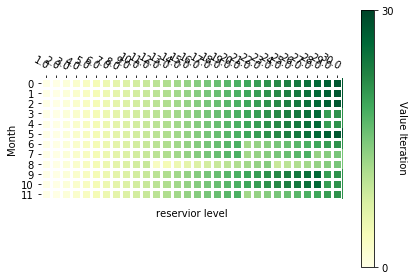

In [31]:
import FigureFunc
policyplot(opt_policy, States, kwargs["prod_cap"], mode)
policyplot(opt_policy_robust, States, kwargs["prod_cap"], mode)

In [28]:
import matplotlib
import matplotlib.pyplot as plt

def policyplot(policy, States, max_prod, mode):
    month = []
    res_level = []
    # res_level and month

    Data = {(s[0], s[2]): policy.get_state_to_action_map()[s] for s in States}
    for key in Data.keys():
        res_level.append(key[0])
        month.append(key[1])
    res_level = sorted(set(res_level))
    month = sorted(set(month))
    values = np.zeros((len(res_level), len(month)))
    for i, elem1 in enumerate(res_level):
        for j, elem2 in enumerate(month):
            values[i, j] = policy.get_state_to_action_map()[(elem1, 0., elem2)]
    
            
    #res_level and month
    fig, ax = plt.subplots()
    im, cbar = FigureFunc.heatmap(values.T,  month, res_level , ax=ax, cbar_kw = {'ticks': [0.0, max_prod]},  cmap="YlGn", cbarlabel="%s Value Iteration "%mode,\
                                  vmin = 0., vmax = max_prod )
    #texts = annotate_heatmap(im, valfmt="{x:.1f} t")
    ax.set_ylabel("Month")
    ax.set_xlabel("reservior level")
    fig.tight_layout()
    plt.show()        

In [15]:
States = sorted(States)
# for s in States:
#     #print("s:{}, Robust: {}, nominal: {}\n".format(s, opt_policy_robust.get_state_to_action_map()[s], opt_policy.get_state_to_action_map()[s]))
#     if value_function[s] > value_function_robust[s]:
#         print("(res_level, condition, month) : {}, value_function: {}, robust_value_function: {}".format(s, value_function[s], value_function_robust[s]))
for s in States:
    print(s, opt_policy.get_state_to_action_map()[s], opt_policy_robust.get_state_to_action_map()[s])

(1, 0.0, 0) 0 0
(1, 0.0, 1) 0 0
(1, 0.0, 2) 0 0
(1, 0.0, 3) 0 0
(1, 0.0, 4) 0 0
(1, 0.0, 5) 0 0
(1, 0.0, 6) 0 0
(1, 0.0, 7) 0 0
(1, 0.0, 8) 0 0
(1, 0.0, 9) 0 0
(1, 0.0, 10) 0 0
(1, 0.0, 11) 0 0
(2, 0.0, 0) 0.0 0.0
(2, 0.0, 1) 0.0 0.0
(2, 0.0, 2) 0.0 0.0
(2, 0.0, 3) 0.0 0.0
(2, 0.0, 4) 0.0 0.0
(2, 0.0, 5) 0.0 0.0
(2, 0.0, 6) 0.0 0.0
(2, 0.0, 7) 0.0 0.0
(2, 0.0, 8) 0.0 0.0
(2, 0.0, 9) 0.0 0.0
(2, 0.0, 10) 0.0 0.0
(2, 0.0, 11) 0.0 0.0
(3, 0.0, 0) 1.0 1.0
(3, 0.0, 1) 1.0 1.0
(3, 0.0, 2) 1.0 1.0
(3, 0.0, 3) 1.0 1.0
(3, 0.0, 4) 1.0 0.0
(3, 0.0, 5) 1.0 0.0
(3, 0.0, 6) 0.0 0.0
(3, 0.0, 7) 0.0 0.0
(3, 0.0, 8) 0.0 0.0
(3, 0.0, 9) 0.0 0.0
(3, 0.0, 10) 0.0 0.0
(3, 0.0, 11) 0.0 0.0
(4, 0.0, 0) 2.0 2.0
(4, 0.0, 1) 2.0 2.0
(4, 0.0, 2) 2.0 2.0
(4, 0.0, 3) 2.0 2.0
(4, 0.0, 4) 2.0 0.0
(4, 0.0, 5) 2.0 0.0
(4, 0.0, 6) 0.0 0.0
(4, 0.0, 7) 0.0 0.0
(4, 0.0, 8) 0.0 0.0
(4, 0.0, 9) 0.0 0.0
(4, 0.0, 10) 0.0 0.0
(4, 0.0, 11) 0.0 0.0
(5, 0.0, 0) 3.0 3.0
(5, 0.0, 1) 3.0 3.0
(5, 0.0, 2) 3.0 3.0
(5, 0.0, 3) 3.0 3.0


(46, 0.0, 11) 0.0 0.0
(47, 0.0, 0) 19.0 19.0
(47, 0.0, 1) 19.0 19.0
(47, 0.0, 2) 19.0 19.0
(47, 0.0, 3) 19.0 19.0
(47, 0.0, 4) 19.0 19.0
(47, 0.0, 5) 19.0 15.0
(47, 0.0, 6) 0.0 0.0
(47, 0.0, 7) 0.0 0.0
(47, 0.0, 8) 0.0 0.0
(47, 0.0, 9) 15.0 0.0
(47, 0.0, 10) 7.0 0.0
(47, 0.0, 11) 0.0 0.0
(48, 0.0, 0) 19.0 19.0
(48, 0.0, 1) 19.0 19.0
(48, 0.0, 2) 19.0 19.0
(48, 0.0, 3) 19.0 19.0
(48, 0.0, 4) 19.0 19.0
(48, 0.0, 5) 19.0 16.0
(48, 0.0, 6) 0.0 0.0
(48, 0.0, 7) 0.0 0.0
(48, 0.0, 8) 0.0 0.0
(48, 0.0, 9) 16.0 0.0
(48, 0.0, 10) 8.0 0.0
(48, 0.0, 11) 1.0 0.0
(49, 0.0, 0) 19.0 19.0
(49, 0.0, 1) 19.0 19.0
(49, 0.0, 2) 19.0 19.0
(49, 0.0, 3) 19.0 19.0
(49, 0.0, 4) 19.0 19.0
(49, 0.0, 5) 19.0 17.0
(49, 0.0, 6) 0.0 0.0
(49, 0.0, 7) 0.0 0.0
(49, 0.0, 8) 0.0 0.0
(49, 0.0, 9) 17.0 0.0
(49, 0.0, 10) 9.0 0.0
(49, 0.0, 11) 2.0 0.0
(50, 0.0, 0) 19.0 19.0
(50, 0.0, 1) 19.0 19.0
(50, 0.0, 2) 19.0 19.0
(50, 0.0, 3) 19.0 19.0
(50, 0.0, 4) 19.0 19.0
(50, 0.0, 5) 19.0 18.0
(50, 0.0, 6) 0.0 0.0
(50, 0.0, 7) 0.0 0

(103, 0.0, 2) 19.0 19.0
(103, 0.0, 3) 19.0 19.0
(103, 0.0, 4) 19.0 19.0
(103, 0.0, 5) 19.0 19.0
(103, 0.0, 6) 0.0 0.0
(103, 0.0, 7) 0.0 0.0
(103, 0.0, 8) 0.0 0.0
(103, 0.0, 9) 19.0 19.0
(103, 0.0, 10) 19.0 19.0
(103, 0.0, 11) 19.0 19.0
(104, 0.0, 0) 19.0 19.0
(104, 0.0, 1) 19.0 19.0
(104, 0.0, 2) 19.0 19.0
(104, 0.0, 3) 19.0 19.0
(104, 0.0, 4) 19.0 19.0
(104, 0.0, 5) 19.0 19.0
(104, 0.0, 6) 0.0 0.0
(104, 0.0, 7) 0.0 0.0
(104, 0.0, 8) 0.0 0.0
(104, 0.0, 9) 19.0 19.0
(104, 0.0, 10) 19.0 19.0
(104, 0.0, 11) 19.0 19.0
(105, 0.0, 0) 19.0 19.0
(105, 0.0, 1) 19.0 19.0
(105, 0.0, 2) 19.0 19.0
(105, 0.0, 3) 19.0 19.0
(105, 0.0, 4) 19.0 19.0
(105, 0.0, 5) 19.0 19.0
(105, 0.0, 6) 0.0 0.0
(105, 0.0, 7) 0.0 0.0
(105, 0.0, 8) 0.0 0.0
(105, 0.0, 9) 19.0 19.0
(105, 0.0, 10) 19.0 19.0
(105, 0.0, 11) 19.0 19.0
(106, 0.0, 0) 19.0 19.0
(106, 0.0, 1) 19.0 19.0
(106, 0.0, 2) 19.0 19.0
(106, 0.0, 3) 19.0 19.0
(106, 0.0, 4) 19.0 19.0
(106, 0.0, 5) 19.0 19.0
(106, 0.0, 6) 0.0 0.0
(106, 0.0, 7) 0.0 0.0
(106, 0.

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
Robust_dic = opt_policy_robust.get_state_to_action_map()
dic = opt_policy.get_state_to_action_map()
lst_robust = []
lst = []
x_res = []
y_month = []
for key in Robust_dic.keys():
    if Robust_dic[key] != dic[key]:
        lst_robust.append(Robust_dic[key])
        lst.append(dic[key])
        x_res.append(key[0])
        y_month.append(key[2])
# lst_robust = np.array(lst_robust)
# lst = np.array(lst)
# x_res = np.array(x_res)
# y_month = np.array(y_month)
print(len(lst_robust), len(lst), len(x_res))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(x_res, y_month, lst_robust, c='r', marker='o', label= "Robsut_policy")
ax.scatter(x_res, y_month, lst, c='b', marker='^')
ax.set_xlabel('Reservior level')
ax.set_ylabel('Month')
ax.set_zlabel('Policy')
ax.legend()
plt.show()        
        

KeyError: (105.0, 0.0, 0)

In [31]:

data = zip(y_month, x_res, lst_robust, lst)
for elem in sorted(data):
    print("(month, reservior level): {}, robust_policy : {}, nominal policy: {}".format(elem[0:2], elem[2], elem[3]))

(month, reservior level): (0, 16), robust_policy : 4, nominal policy: 0
(month, reservior level): (0, 17), robust_policy : 4, nominal policy: 0
(month, reservior level): (1, 16), robust_policy : 4, nominal policy: 0
(month, reservior level): (1, 17), robust_policy : 4, nominal policy: 0
(month, reservior level): (2, 16), robust_policy : 4, nominal policy: 0
(month, reservior level): (2, 17), robust_policy : 4, nominal policy: 0
(month, reservior level): (3, 16), robust_policy : 4, nominal policy: 0
(month, reservior level): (3, 17), robust_policy : 4, nominal policy: 0
(month, reservior level): (4, 16), robust_policy : 4, nominal policy: 0
(month, reservior level): (4, 17), robust_policy : 4, nominal policy: 0
(month, reservior level): (5, 17), robust_policy : 4, nominal policy: 0
(month, reservior level): (6, 17), robust_policy : 4, nominal policy: 0
(month, reservior level): (7, 17), robust_policy : 4, nominal policy: 0
(month, reservior level): (8, 17), robust_policy : 4, nominal po

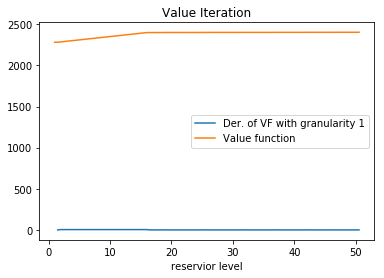

In [7]:
import matplotlib
import matplotlib.pyplot as plt
month = []
res_level = []
# parameters: [array([ 0.09999475,  0.09999931,  0.,  0.099999])]
# 
Data = {(s[0]): value_function[s] for s in States}

for key in Data.keys():
    res_level.append(key)
res_level = sorted(set(res_level))
values = np.zeros(len(res_level))
for i, elem1 in enumerate(res_level):
    values[i] = value_function[(elem1, 0., 0.)]
der_value = np.zeros(len(res_level)-1)
der_res = np.zeros(len(res_level)-1)
for num in range(1, len(res_level)):
    der_value[num-1] = (values[num] - values[num-1])
    der_res[num-1] = res_level[num] 
#res_level and derivative
fig = plt.figure()
fig.subplots_adjust()
ax1 = fig.add_subplot(111)
ax1.set_xlabel("reservior level")
ax1.set_title("Value Iteration")
ax1.plot(der_res, der_value, label = "Der. of VF with granularity 1")
#ax1.plot(res_level, values, label = "Value function")
ax1.legend()
#ax1.set_xticks(np.arange(min(der_res), max(der_res)+1, 1.0))
plt.show()

In [ ]:
# heatmap for policy


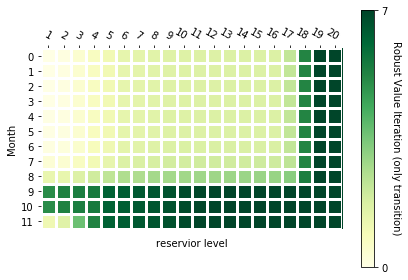

In [47]:
import matplotlib
import matplotlib.pyplot as plt
import FigureFunc
month = []
res_level = []
# res_level and month

Data = {(s[0], s[2]): value_function_robust[s] for s in States}
for key in Data.keys():
    res_level.append(key[0])
    month.append(key[1])
res_level = sorted(set(res_level))
month = sorted(set(month))
values = np.zeros((len(res_level), len(month)))
for i, elem1 in enumerate(res_level):
    for j, elem2 in enumerate(month):
        values[i, j] = value_function_robust[(elem1, 0., elem2)]
#res_level and month
fig, ax = plt.subplots()

im, cbar = FigureFunc.heatmap(values.T, month, res_level, ax=ax, cbar_kw = {'ticks': [0.0, 7.]},  cmap="YlGn", cbarlabel="Robust Value Iteration (only transition) ",\
                              vmin = 0., vmax = 7. )
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")
ax.set_ylabel("Month")
ax.set_xlabel("reservior level")
fig.tight_layout()
plt.show()        

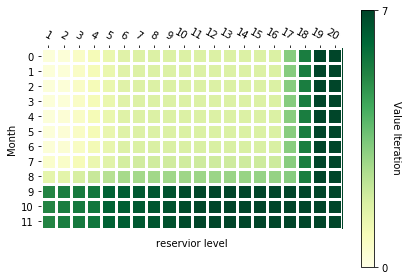

In [46]:
import matplotlib
import matplotlib.pyplot as plt
month = []
res_level = []
# res_level and month

Data = {(s[0], s[2]): value_function[s] for s in States}
for key in Data.keys():
    res_level.append(key[0])
    month.append(key[1])
res_level = sorted(set(res_level))
month = sorted(set(month))
values = np.zeros((len(res_level), len(month)))
for i, elem1 in enumerate(res_level):
    for j, elem2 in enumerate(month):
        values[i, j] = value_function[(elem1, 0., elem2)]
#res_level and month
fig, ax = plt.subplots()
im, cbar = FigureFunc.heatmap(values.T,  month, res_level , ax=ax, cbar_kw = {'ticks': [0.0, 7.0]},  cmap="YlGn", cbarlabel="Value Iteration ",\
                              vmin = 0., vmax = 7. )
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")
ax.set_ylabel("Month")
ax.set_xlabel("reservior level")
fig.tight_layout()
plt.show()        

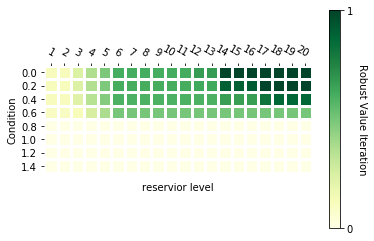

In [132]:
# Res_level and condition

import matplotlib
import matplotlib.pyplot as plt
condition = []
res_level = []

Data = {(s[0], s[1]): value_function_robust[s] for s in States}
for key in Data.keys():
    res_level.append(key[0])
    condition.append(key[1])
res_level = sorted(set(res_level))
condition = sorted(set(condition))
values = np.zeros((len(res_level), len(condition)))
for i, elem1 in enumerate(res_level):
    for j, elem2 in enumerate(condition):
        values[i, j] = value_function_robust[(elem1, elem2, 0.)]
#res_level and month
fig, ax = plt.subplots()
im, cbar = FigureFunc.heatmap(values.T, condition, res_level , ax=ax , cbar_kw = {'ticks': [0.0, 1]}, cmap="YlGn", cbarlabel="Robust Value Iteration",
                             vmin =0 ,vmax = 1)
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")
ax.set_ylabel("Condition")
ax.set_xlabel("reservior level")

plt.show()        


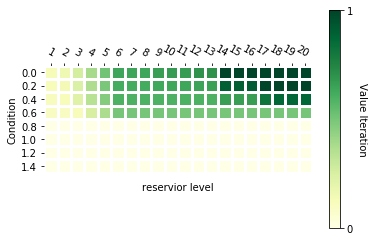

In [133]:
# Res_level and condition

import matplotlib
import matplotlib.pyplot as plt
condition = []
res_level = []

Data = {(s[0], s[1]): value_function[s] for s in States}
for key in Data.keys():
    res_level.append(key[0])
    condition.append(key[1])
res_level = sorted(set(res_level))
condition = sorted(set(condition))
values = np.zeros((len(res_level), len(condition)))
for i, elem1 in enumerate(res_level):
    for j, elem2 in enumerate(condition):
        values[i, j] = value_function[(elem1, elem2, 0.)]
#res_level and month
fig, ax = plt.subplots()
im, cbar = FigureFunc.heatmap(values.T, condition, res_level, ax=ax, cbar_kw = {'ticks': [0.0, 1]}, cmap="YlGn", cbarlabel="Value Iteration",
                  vmin =0 ,vmax = 1)
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")
ax.set_ylabel("Condition")
ax.set_xlabel("reservior level")

plt.show()        
